In [1]:
VERSION = 31
CLOUD_SINGLE = True
DATA_SMALL = False
FOCAL_LOSS = False

In [5]:
%run ./Code.ipynb

# Utility

In [6]:
def myLabelEncoder(data, col, vals, remaining_cat = True):
    name = col+'_le'
    enc_df = pd.DataFrame(np.arange(len(vals)), index=vals, columns = [name])
    data = data.join(enc_df, on=col)

    if remaining_cat:
        data[name] = data[name].fillna(len(vals))
    else:
        assert data[name].isnull().sum() == 0
    
    data[name] = data[name].astype(int).astype('category')
    assert len(data[name].unique()) == (len(vals) + remaining_cat)
    
    return data

In [7]:
def myRoundEncoder(data, col, rounding, postfix):
    name = col+postfix
    data[name] = (((data[col]+0.0000001) % rounding) < 0.00001)
    data[name] = data[name].astype(bool)
    return data

# Prepare metadata

In [66]:
cols_info = ['PatientID','SOPInstanceUID','SeriesInstanceUID','StudyInstanceUID','pos_idx','Rows','Columns',
             'PxlMin_zero','any_series','test','test2']
cols_redundant = ['BitsAllocated','HighBit','WindowCenter_1_NAN','ImageOrientationPatient_0','ImageOrientationPatient_1',
                  'ImageOrientationPatient_2','ImageOrientationPatient_3','PixelSpacing_0','Modality',
                  'PhotometricInterpretation','SamplesPerPixel','StudyID',
                  'ImageOrientationPatient_5_enc_1', # same as ImageOrientationPatient_4_enc_1
                  'PixelSpacing_1_enc_1', # same as ImagePositionPatient_0_enc_1
                 ]
cols_consumed = ['BitsStored','PixelRepresentation','RescaleIntercept','ImageOrientationPatient',
                 'ImageOrientationPatient_4','ImageOrientationPatient_5','ImagePositionPatient',
                 'ImagePositionPatient_0','ImagePositionPatient_1','ImagePositionPatient_2','PixelSpacing',
                 'RescaleSlope','WindowCenter','PixelSpacing_1','WindowCenter_0','WindowCenter_1',
                 'WindowWidth','WindowWidth_0','WindowWidth_1']
cols_float = ['ImageOrientationPatient_4_f','ImageOrientationPatient_5_f','ImagePositionPatient_0_f',
              'ImagePositionPatient_1_f','ImagePositionPatient_2_f','PixelSpacing_1_f',
              'pos_max','pos_min','pos_size','pos_idx1','pos_idx2','pos_inc1','pos_inc2',
              'pos_range','pos_rel','pos_zeros','pos_inc_rng','PxlMin','PxlMax','PxlStd','PxlMean','SeriesPP']
cols_bool = ['ImageOrientationPatient_4_enc_0','ImageOrientationPatient_4_enc_1',
             'ImageOrientationPatient_5_enc_0',
             'ImagePositionPatient_0_enc_0','ImagePositionPatient_0_enc_1',
             'ImagePositionPatient_0_f_r1','ImagePositionPatient_0_f_r05','ImagePositionPatient_1_enc_0',
             'ImagePositionPatient_2_f_r05','PixelSpacing_1_enc_0',
             'pos_inc1_r1','pos_inc1_r0001','pos_inc1_enc_0','pos_inc2_enc_0','pos_inc1_enc_1','pos_inc2_enc_1']
cols_le = ['WindowCenter_1_le','BitType_le','WindowCenter_0_le','pos_inc1_grp_le','pos_inc2_grp_le','pos_size_le',
           'pos_zeros_le','WindowWidth_0_le','WindowWidth_1_le','PxlMin_grp_le']

cols_all = cols_redundant + cols_float + cols_bool + cols_le + cols_consumed + cols_info

In [67]:
pickle.dump((cols_le,cols_float,cols_bool), open(PATH_WORK/'covs','wb'))

In [10]:
train_csv = pd.read_csv(PATH/'stage_2_train.csv')

train_csv = train_csv.loc[~train_csv.ID.duplicated()].sort_values('ID').reset_index(drop=True)
all_sop_ids = train_csv.ID.str.split('_').apply(lambda x: x[0]+'_'+x[1]).unique()
train_df = pd.DataFrame(train_csv.Label.values.reshape((-1,6)), columns = all_ich)
train_df['sop_id'] = all_sop_ids

train_df.to_csv(PATH_WORK/'train_df.csv', index=False)

In [11]:
train_md = pd.read_csv(PATH/'train_metadata.csv')
train_md['test'] = False
test_md = pd.read_csv(PATH/'test_metadata.csv')
test_md['test'] = True
data_md = pd.concat([train_md, test_md], axis=0, sort=False).reset_index(drop=True)

In [12]:
data_md['test2'] = False
test2_md = pd.read_csv(PATH/'test2_metadata.csv')
test2_md['test'] = False
test2_md['test2'] = True
data_md = pd.concat([data_md, test2_md], axis=0, sort=False).reset_index(drop=True)

In [13]:
data_md.columns = data_md.columns.str.replace('_',' ').str.title().str.replace(' ','').str.replace('Sop','SOP')\
    .str.replace('Uid','UID').str.replace('Id','ID')

In [52]:
cc = data_md.columns.values
cc[cc == 'Test'] = 'test'
cc[cc == 'Test2'] = 'test2'
data_md.columns = cc

In [14]:
for i in range(6):
    data_md['ImageOrientationPatient_{}'.format(i)] \
        = data_md['ImageOrientationPatient'].str.split('\'').apply(lambda x: x[1+2*i])

for i in range(3):
    data_md['ImagePositionPatient_{}'.format(i)] \
        = data_md['ImagePositionPatient'].str.split('\'').apply(lambda x: x[1+2*i])

for i in range(2):
    data_md['PixelSpacing_{}'.format(i)] \
        = data_md['PixelSpacing'].str.split('\'').apply(lambda x: x[1+2*i])

data_md['WindowCenter_0'] \
    = data_md['WindowCenter'].str.split('\'').apply(lambda x: float(x[1]) if len(x) > 1 else float(x[0]))

data_md['WindowCenter_1'] \
    = data_md['WindowCenter'].str.split('\'').apply(lambda x: float(x[3]) if len(x) > 1 else np.nan)

data_md['WindowCenter_1_NAN'] = data_md.WindowCenter_1.isnull()

In [16]:
data_md['ImagePositionPatient_2'] = data_md['ImagePositionPatient_2'].astype(float)
data_md = data_md.sort_values(['SeriesInstanceUID','ImagePositionPatient_2']).reset_index(drop=True)

In [17]:
data_md['WindowWidth_0'] \
    = data_md['WindowWidth'].str.split('\'').apply(lambda x: float(x[1]) if len(x) > 1 else float(x[0]))

data_md['WindowWidth_1'] \
    = data_md['WindowWidth'].str.split('\'').apply(lambda x: float(x[3]) if len(x) > 1 else np.nan)

data_md = myLabelEncoder(data_md, 'WindowWidth_0', [80.0,150.0,100.0,135.0,120.0])

data_md = myLabelEncoder(data_md, 'WindowWidth_1', [80.0,np.nan])

In [18]:
data_md = myLabelEncoder(data_md, 'WindowCenter_1', [36.0,40.0,47.0,np.nan])

In [19]:
data_md['BitType'] = data_md.BitsStored.astype(str) + data_md.PixelRepresentation.astype(str) \
    + data_md.RescaleIntercept.astype(str)

data_md = myLabelEncoder(data_md, 'BitType', ['161-1024.0','120-1024.0','1210.0','1610.0'])

del data_md['BitType']

In [20]:
data_md['ImageOrientationPatient_4_f'] = data_md.ImageOrientationPatient_4.astype(float)

data_md['ImageOrientationPatient_4_enc_0'] = (data_md.ImageOrientationPatient_4_f == 1)
data_md['ImageOrientationPatient_4_enc_1'] = data_md.ImageOrientationPatient_4_f.between(0.927184,0.927185)

data_md['ImageOrientationPatient_4_f'] = np.clip(data_md['ImageOrientationPatient_4_f'].values,0.85,1)

data_md.loc[data_md.ImageOrientationPatient_4_enc_0 | data_md.ImageOrientationPatient_4_enc_1, \
            'ImageOrientationPatient_4_f'] = 0.7

In [21]:
data_md['ImageOrientationPatient_5_f'] = data_md.ImageOrientationPatient_5.astype(float)

data_md['ImageOrientationPatient_5_enc_0'] = (data_md.ImageOrientationPatient_5_f == 0)
data_md['ImageOrientationPatient_5_enc_1'] = data_md.ImageOrientationPatient_5_f.between(-0.374608,-0.374607)

data_md.loc[data_md.ImageOrientationPatient_5_enc_0 | data_md.ImageOrientationPatient_5_enc_1, \
            'ImageOrientationPatient_5_f'] = -0.6

data_md['ImageOrientationPatient_5_f'] = np.clip(data_md['ImageOrientationPatient_5_f'].values,-0.7,0)

In [22]:
data_md['ImagePositionPatient_0_f'] = data_md.ImagePositionPatient_0.astype(float)

data_md['ImagePositionPatient_0_enc_0'] = (data_md.ImagePositionPatient_0_f == -125)
data_md['ImagePositionPatient_0_enc_1'] = (data_md.ImagePositionPatient_0_f.between(-126.437379,-126.437377) |
                                           data_md.ImagePositionPatient_0_f.between(-126.408876,-126.408874))

data_md['ImagePositionPatient_0_f'] = np.clip(data_md['ImagePositionPatient_0_f'].values,-175,-50)

data_md.loc[data_md.ImagePositionPatient_0_enc_0 | data_md.ImagePositionPatient_0_enc_1, \
            'ImagePositionPatient_0_f'] = -200

In [23]:
data_md = myRoundEncoder(data_md, 'ImagePositionPatient_0_f', 1, '_r1')
data_md = myRoundEncoder(data_md, 'ImagePositionPatient_0_f', 0.5, '_r05')

In [24]:
data_md['ImagePositionPatient_1_f'] = data_md.ImagePositionPatient_1.astype(float)
data_md['ImagePositionPatient_1_f'] = np.clip(data_md['ImagePositionPatient_1_f'].values,-200,100)
data_md['ImagePositionPatient_1_enc_0'] = (data_md['ImagePositionPatient_1_f'] > -75)

In [25]:
data_md['ImagePositionPatient_2_f'] = data_md.ImagePositionPatient_2.astype(float)
data_md = myRoundEncoder(data_md, 'ImagePositionPatient_2_f', 0.5, '_r05')

In [26]:
data_md['PixelSpacing_1_f'] = data_md.PixelSpacing_1.astype(float)

data_md['PixelSpacing_1_enc_0'] = (data_md.PixelSpacing_1_f.between(0.488281,0.488282))
data_md['PixelSpacing_1_enc_1'] = (data_md.PixelSpacing_1_f.between(0.494750,0.494864))

data_md['PixelSpacing_1_f'] = np.clip(data_md['PixelSpacing_1_f'].values,0.3,0.7)

data_md.loc[data_md.PixelSpacing_1_enc_0 | data_md.PixelSpacing_1_enc_1, 'PixelSpacing_1_f'] = 0.2

In [27]:
data_md = myLabelEncoder(data_md, 'WindowCenter_0', [30.0,36.0,40.0,35.0,47.0,50.0])

In [28]:
data_md['pos_max'] = data_md[['SeriesInstanceUID','ImagePositionPatient_2']]\
    .groupby('SeriesInstanceUID').transform(lambda x: max(x))
data_md['pos_min'] = data_md[['SeriesInstanceUID','ImagePositionPatient_2']]\
    .groupby('SeriesInstanceUID').transform(lambda x: min(x))
data_md['pos_size'] = data_md[['SeriesInstanceUID','ImagePositionPatient_2']]\
    .groupby('SeriesInstanceUID').transform(lambda x: len(x))

In [29]:
data_md['pos_idx1'] = data_md[['SeriesInstanceUID','ImagePositionPatient_2']]\
    .groupby('SeriesInstanceUID').transform(lambda x: np.arange(len(x)))
data_md['pos_idx'] = data_md['pos_idx1']

In [30]:
data_md['pos_idx2'] = data_md[['SeriesInstanceUID','ImagePositionPatient_2']]\
    .groupby('SeriesInstanceUID').transform(lambda x: np.arange(len(x))[::-1])

In [31]:
data_md['pos_inc1'] = data_md[['SeriesInstanceUID','ImagePositionPatient_2']]\
    .groupby('SeriesInstanceUID').transform(lambda x: np.concatenate([[0],np.diff(x.values)]))
data_md['pos_inc2'] = data_md[['SeriesInstanceUID','ImagePositionPatient_2']]\
    .groupby('SeriesInstanceUID').transform(lambda x: np.concatenate([np.diff(x.values),[0]]))

In [32]:
data_md['pos_inc1_grp'] = pd.cut(data_md.pos_inc1, [-1,2.0,3.5,4.5,1000], labels=np.arange(4))
data_md = myLabelEncoder(data_md, 'pos_inc1_grp', [0,1,2,3], remaining_cat=False)

del data_md['pos_inc1_grp']

data_md['pos_inc2_grp'] = pd.cut(data_md.pos_inc2, [-1,2.0,3.5,4.5,1000], labels=np.arange(4))
data_md = myLabelEncoder(data_md, 'pos_inc2_grp', [0,1,2,3], remaining_cat=False)

del data_md['pos_inc2_grp']

In [33]:
data_md = myRoundEncoder(data_md, 'pos_inc1', 1, '_r1')
data_md = myRoundEncoder(data_md, 'pos_inc1', 0.001, '_r0001')

In [34]:
data_md['pos_inc1_enc_0'] = (data_md.pos_inc1 == 0)
data_md['pos_inc2_enc_0'] = (data_md.pos_inc2 == 0)
data_md['pos_inc1_enc_1'] = (data_md.pos_inc1 == 5)
data_md['pos_inc2_enc_1'] = (data_md.pos_inc2 == 5)

data_md['pos_inc1'] = np.clip(data_md['pos_inc1'].values,0,7)
data_md['pos_inc2'] = np.clip(data_md['pos_inc2'].values,0,7)

data_md.loc[data_md.pos_inc1_enc_0 | data_md.pos_inc1_enc_1, 'pos_inc1'] = -1
data_md.loc[data_md.pos_inc2_enc_0 | data_md.pos_inc2_enc_1, 'pos_inc2'] = -1

In [35]:
data_md = myLabelEncoder(data_md, 'pos_size', [32,40,36,28,34,30,35,33,38,44])

In [36]:
data_md['pos_range'] = (data_md['pos_max'] - data_md['pos_min'])
data_md['pos_rel'] = ((data_md['ImagePositionPatient_2'] - data_md['pos_min'])/data_md['pos_range'])\
    .where(data_md['pos_range'] > 0, 0.5)

data_md['pos_zeros'] = data_md[['SeriesInstanceUID','ImagePositionPatient_2']]\
    .groupby('SeriesInstanceUID').transform(lambda x: (np.diff(x.values) <= 0.001).sum())

data_md['pos_inc_rng'] = data_md[['SeriesInstanceUID','ImagePositionPatient_2']]\
    .groupby('SeriesInstanceUID').transform(lambda x: np.diff(x.values)[np.diff(x.values) > 0.1].max() /
                                                      np.diff(x.values)[np.diff(x.values) > 0.1].min())

data_md['pos_inc_rng'] = np.clip(data_md['pos_inc_rng'],0,3)

In [37]:
data_md['pos_min'] = np.clip(data_md['pos_min'].values,-500,500)
data_md['pos_max'] = np.clip(data_md['pos_max'].values,-500,500)

In [38]:
data_md['pos_range'] = np.clip(data_md['pos_range'].values,100,250)

data_md = myLabelEncoder(data_md, 'pos_zeros', [0,4,8])

In [39]:
data_md['PxlStd'] = np.clip(data_md['PxlStd'].values,0,1500)
data_md['PxlMean'] = np.clip(data_md['PxlMean'].values,-1900,-100)
data_md['PxlMin'] = np.clip(data_md['PxlMin'].values,-3500,-1000)
data_md['PxlMax'] = np.clip(data_md['PxlMax'].values,-1000,3500)

In [40]:
data_md['PxlMin_grp'] = pd.cut(data_md.PxlMin, [-5000,-2500,-1500,2000], labels=np.arange(3))
data_md = myLabelEncoder(data_md, 'PxlMin_grp', [0,1,2], remaining_cat=False)
del data_md['PxlMin_grp']

In [41]:
cnts = data_md[['SeriesInstanceUID','PxlMin_grp_le']].groupby('SeriesInstanceUID').agg(lambda x: (x == 0).sum() > 10)
cnts.columns = ['PxlMin_zero']
data_md = data_md.join(cnts, on = 'SeriesInstanceUID')

In [42]:
data_md = data_md.join(train_df.set_index('sop_id'), on = 'SOPInstanceUID')

In [59]:
assert data_md['any'].isnull().sum() == 121232

In [61]:
pd.crosstab([data_md.PxlMin_grp_le, data_md.PxlMin_zero],
             [data_md.test, data_md.test2])

test                        False         True 
test2                       False  True   False
PxlMin_grp_le PxlMin_zero                      
0             False           126     17      4
              True         227189  37123  73512
1             False         83433  16840   1095
2             False        363509  67252   3934

In [62]:
cnts = data_md[['SeriesInstanceUID','any']].groupby('SeriesInstanceUID').agg(lambda x: x.sum() > 0)
cnts.columns = ['any_series']
data_md = data_md.join(cnts, on = 'SeriesInstanceUID')

In [63]:
data_md.any_series.value_counts()

False    573100
True     300934
Name: any_series, dtype: int64

In [64]:
cnts = data_md[['SeriesInstanceUID','PatientID']].groupby('PatientID').agg(lambda x: x.nunique())
cnts.columns = ['SeriesPP']
data_md = data_md.join(cnts, on='PatientID')

In [68]:
assert len([col for col in cols_all if col not in data_md.columns]) == 0
assert len([col for col in data_md.columns if col not in (cols_all + all_ich)]) == 0

In [69]:
data_md.to_csv(PATH_WORK/'data_md.csv', index=False)

In [70]:
for col in (cols_float + cols_bool):
    data_md[col] = data_md[col].astype(float)

#for col in cols_cat:
#    data_md[col] = pd.factorize(data_md[col])[0]
#    data_md[col] = data_md[col].astype('category')

In [71]:
M = 4
data_md['ImageOrientationPatient_4_f'] = M*(data_md['ImageOrientationPatient_4_f'] - 0.8)/0.3
data_md['ImageOrientationPatient_5_f'] = M*(data_md['ImageOrientationPatient_5_f'] + 0.5)/0.6
data_md['ImagePositionPatient_0_f'] =    M*(data_md['ImagePositionPatient_0_f'] + 173)/150
data_md['ImagePositionPatient_1_f'] =    M*(data_md['ImagePositionPatient_1_f'] + 65)/300
data_md['ImagePositionPatient_2_f'] =    M*(data_md['ImagePositionPatient_2_f'] - 167)/2792
data_md['PixelSpacing_1_f'] =            M*(data_md['PixelSpacing_1_f'] - 0.26)/0.5
data_md['pos_max'] =                     M*(data_md['pos_max'])/1000
data_md['pos_min'] =                     M*(data_md['pos_min'])/1000
data_md['pos_size'] =                    M*(data_md['pos_size'] - 35)/40
data_md['pos_idx1'] =                    M*(data_md['pos_idx1'] - 17)/59
data_md['pos_idx2'] =                    M*(data_md['pos_idx2'] - 17)/59
data_md['pos_inc1'] =                    M*(data_md['pos_inc1'] - 2)/8
data_md['pos_inc2'] =                    M*(data_md['pos_inc2'] - 2)/8
data_md['pos_range'] =                   M*(data_md['pos_range'] - 165)/150
data_md['pos_rel'] =                     M*(data_md['pos_rel'] - 0.5)/1.0
data_md['pos_zeros'] =                   M*(data_md['pos_zeros'])/10
data_md['pos_inc_rng'] =                 M*(data_md['pos_inc_rng'] - 1.3)/2.0

data_md['PxlMin'] =                      M*(data_md['PxlMin'] + 2000)/3000
data_md['PxlMax'] =                      M*(data_md['PxlMax'] - 1500)/3000
data_md['PxlMean'] =                     M*(data_md['PxlMean'] + 800)/1000
data_md['PxlStd'] =                      M*(data_md['PxlStd'] - 800)/1000
data_md['SeriesPP'] =                    (data_md['SeriesPP'] - 2)/2

In [72]:
data_md.test.value_counts()

False    795489
True      78545
Name: test, dtype: int64

In [75]:
train_md = data_md.loc[~data_md.test & ~data_md.test2].copy().reset_index(drop=True)
test_md = data_md.loc[data_md.test].copy().reset_index(drop=True)
test2_md = data_md.loc[data_md.test2].copy().reset_index(drop=True)

for col in all_ich:
    train_md[col] = train_md[col].astype(int)
    test_md[col] = test_md[col].astype(int)

train_md.to_csv(PATH_WORK/'train_md.csv', index=False)
test_md.to_csv(PATH_WORK/'test_md.csv', index=False)
test2_md.to_csv(PATH_WORK/'test2_md.csv', index=False)

In [58]:
test_md = pd.read_csv(PATH_WORK/'test_md.csv')
test2_md = pd.read_csv(PATH_WORK/'test2_md.csv')
train_md = pd.read_csv(PATH_WORK/'train_md.csv')

In [76]:
data_md = pd.read_csv(PATH_WORK/'data_md.csv')

# Analysis

In [77]:
for col in cols_le:
    print(col, len(data_md[col].unique()))

WindowCenter_1_le 5
BitType_le 5
WindowCenter_0_le 7
pos_inc1_grp_le 4
pos_inc2_grp_le 4
pos_size_le 11
pos_zeros_le 4
WindowWidth_0_le 6
WindowWidth_1_le 3
PxlMin_grp_le 3


In [78]:
train_md[cols_float].mean()

ImageOrientationPatient_4_f    0.058563
ImageOrientationPatient_5_f    0.222398
ImagePositionPatient_0_f       0.048668
ImagePositionPatient_1_f       0.066942
ImagePositionPatient_2_f       0.010251
PixelSpacing_1_f               0.069438
pos_max                        0.880705
pos_min                        0.261473
pos_size                       0.024645
pos_idx1                       0.008354
pos_idx2                       0.008354
pos_inc1                       0.030327
pos_inc2                       0.030327
pos_range                      0.013157
pos_rel                       -0.057270
pos_zeros                      0.024279
pos_inc_rng                   -0.080632
PxlMin                         0.236361
PxlMax                         0.149736
PxlStd                        -0.032196
PxlMean                        0.124001
SeriesPP                      -0.250615
dtype: float64

In [79]:
train_md[cols_float].std()

ImageOrientationPatient_4_f    1.693531
ImageOrientationPatient_5_f    1.159401
ImagePositionPatient_0_f       1.069924
ImagePositionPatient_1_f       0.866594
ImagePositionPatient_2_f       0.367141
PixelSpacing_1_f               0.915759
pos_max                        0.468271
pos_min                        0.581765
pos_size                       0.536172
pos_idx1                       0.720769
pos_idx2                       0.720769
pos_inc1                       1.502420
pos_inc2                       1.502420
pos_range                      0.489795
pos_rel                        1.198624
pos_zeros                      0.361715
pos_inc_rng                    1.106501
PxlMin                         1.222550
PxlMax                         0.713566
PxlStd                         1.243883
PxlMean                        1.049480
SeriesPP                       0.680281
dtype: float64

In [80]:
cnts = data_md[['SeriesInstanceUID'] + cols_bool]\
    .groupby('SeriesInstanceUID').agg(lambda x: len(x.unique()))

In [81]:
cnts.sum()/cnts.shape[0]

ImageOrientationPatient_4_enc_0    1.000158
ImageOrientationPatient_4_enc_1    1.000158
ImageOrientationPatient_5_enc_0    1.000158
ImagePositionPatient_0_enc_0       1.000119
ImagePositionPatient_0_enc_1       1.000000
ImagePositionPatient_0_f_r1        1.000119
ImagePositionPatient_0_f_r05       1.000119
ImagePositionPatient_1_enc_0       1.000079
ImagePositionPatient_2_f_r05       1.024939
PixelSpacing_1_enc_0               1.000040
pos_inc1_r1                        1.665268
pos_inc1_r0001                     1.428984
pos_inc1_enc_0                     2.000000
pos_inc2_enc_0                     2.000000
pos_inc1_enc_1                     1.435555
pos_inc2_enc_1                     1.435555
dtype: float64

In [82]:
cnts = data_md[['SeriesInstanceUID'] + cols_le]\
    .groupby('SeriesInstanceUID').agg(lambda x: len(x.unique()))

In [83]:
cnts.sum()/cnts.shape[0]

WindowCenter_1_le    1.000000
BitType_le           1.000040
WindowCenter_0_le    1.001742
pos_inc1_grp_le      2.196105
pos_inc2_grp_le      2.196105
pos_size_le          1.000000
pos_zeros_le         1.000000
WindowWidth_0_le     1.023276
WindowWidth_1_le     1.000000
PxlMin_grp_le        1.005621
dtype: float64

In [84]:
cnts.PxlMin_grp_le.value_counts()

1    25120
2      142
Name: PxlMin_grp_le, dtype: int64

In [85]:
significant_cols = []

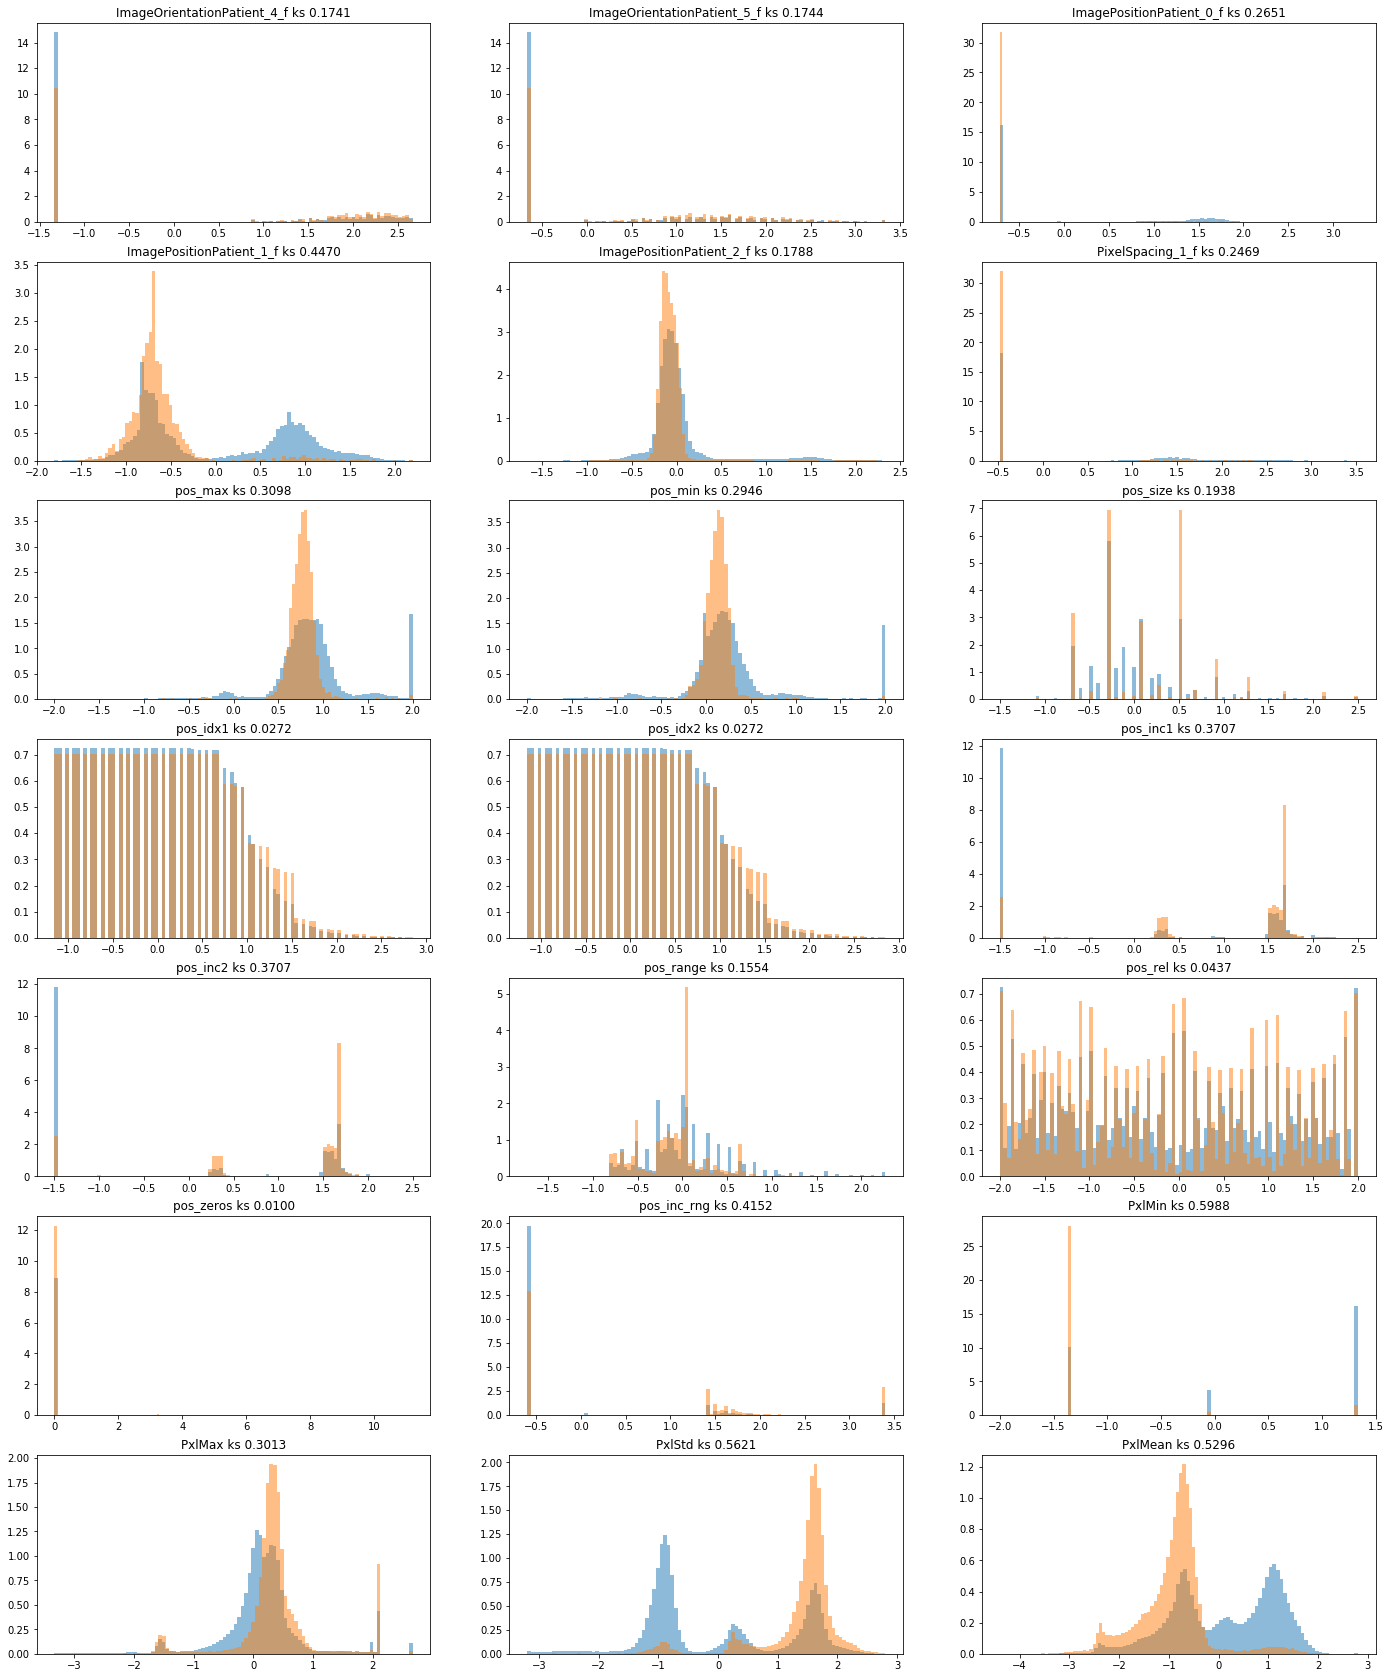

In [86]:
fig, axes = plt.subplots(7, 3, figsize=(24, 30))

for i, ax in enumerate(axes.flatten()):
    if i >= len(cols_float): continue
    col = cols_float[i]
    a = ax.hist(train_md[col], bins=100, density=True, alpha=0.5)
    a = ax.hist(test_md[col], bins=100, density=True, alpha=0.5)
    ks = ks_2samp(train_md[col].values, test_md[col].values)
    ax.set_title(col + (' IMPORTANT' if col in significant_cols else '') + ' ks {:.4f}'.format(ks.statistic))

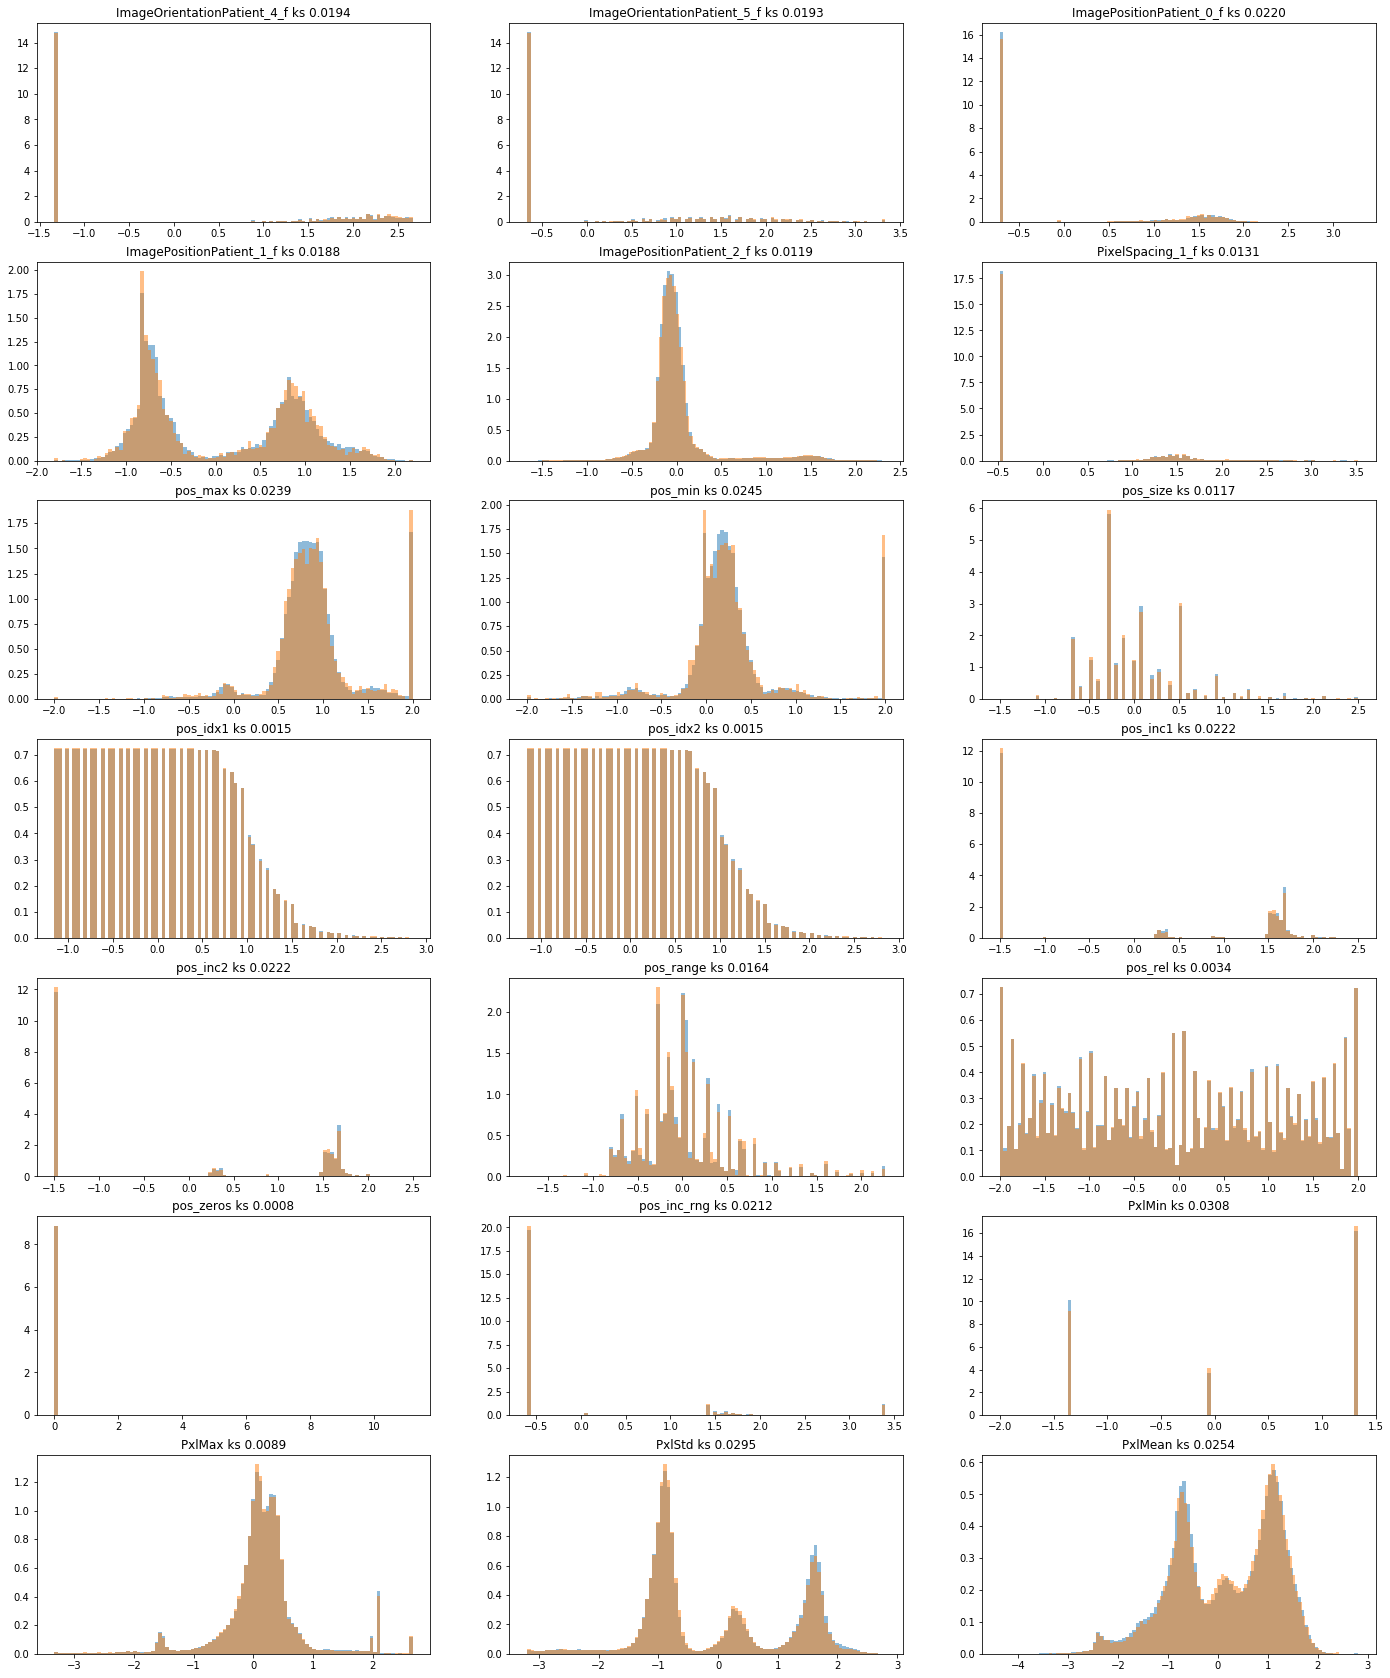

In [87]:
fig, axes = plt.subplots(7, 3, figsize=(24, 30))

for i, ax in enumerate(axes.flatten()):
    if i >= len(cols_float): continue
    col = cols_float[i]
    a = ax.hist(train_md[col], bins=100, density=True, alpha=0.5)
    a = ax.hist(test2_md[col], bins=100, density=True, alpha=0.5)
    ks = ks_2samp(train_md[col].values, test2_md[col].values)
    ax.set_title(col + (' IMPORTANT' if col in significant_cols else '') + ' ks {:.4f}'.format(ks.statistic))

In [88]:
for col in cols_le:
    print(pd.crosstab(data_md[col], data_md['any'].isnull()))

any                 False  True 
WindowCenter_1_le               
0                  250309  44497
1                   71879  13086
2                   10411   2380
3                  417047  60554
4                    3156    715
any          False  True 
BitType_le               
0           414096  59958
1           326639  58793
2             2312    777
3             2951    596
4             6804   1108
any                 False  True 
WindowCenter_0_le               
0                  282676  35234
1                  250309  44497
2                  153344  29149
3                   48586   8214
4                   10377   2380
5                    3957    766
6                    3553    992
any               False   True 
pos_inc1_grp_le                
0                 28873    4410
1                 66891    8446
2                  7817    1474
3                649221  106902
any               False   True 
pos_inc2_grp_le                
0                 28873    4410
1 

In [89]:
pd.crosstab([data_md.BitsStored, data_md.PixelRepresentation, data_md.RescaleIntercept],
             data_md['any'].isnull())

any                                               False  True 
BitsStored PixelRepresentation RescaleIntercept               
12         0                   -1024.0           326639  58793
                               -1000.0             6681   1108
                                0.0                  73      0
                                1.0                  50      0
           1                    0.0                2312    777
16         1                   -1024.0           414096  59958
                                0.0                2951    596

In [90]:
pd.crosstab([train_md.pos_inc2_enc_0 + train_md.pos_inc1_enc_0],
             train_md['any'])

any,0,1
row_0,,
0.0,536963,96762
1.0,40128,340
2.0,63,1


In [91]:
np.corrcoef(train_md['any'], train_md.pos_inc2_enc_0 + train_md.pos_inc1_enc_0)

array([[ 1.        , -0.09758383],
       [-0.09758383,  1.        ]])

In [92]:
bins = data_md.PxlStd.min() + np.arange(301)*(data_md.PxlStd.max() - data_md.PxlStd.min())/300

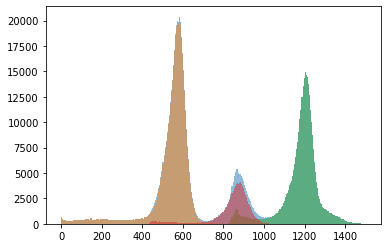

In [93]:
a = plt.hist(data_md.loc[((data_md.PixelRepresentation != 0) | (data_md.RescaleIntercept < 0)) & 
                         (data_md.SOPInstanceUID != 'ID_b79eed528')].PxlStd,
             alpha=0.5,bins=bins)
a = plt.hist(data_md.loc[((data_md.PixelRepresentation != 0) | (data_md.RescaleIntercept < 0)) & 
                         (data_md.SOPInstanceUID != 'ID_b79eed528') & 
                         (data_md.PxlMin > -1500)].PxlStd,
             alpha=0.5,bins=bins)
a = plt.hist(data_md.loc[((data_md.PixelRepresentation != 0) | (data_md.RescaleIntercept < 0)) & 
                         (data_md.SOPInstanceUID != 'ID_b79eed528') & 
                         (data_md.PxlMin < -2500)].PxlStd,
             alpha=0.5,bins=bins)
a = plt.hist(data_md.loc[((data_md.PixelRepresentation != 0) | (data_md.RescaleIntercept < 0)) & 
                         (data_md.SOPInstanceUID != 'ID_b79eed528') & 
                         (data_md.PxlMin.between(-2500,-1500))].PxlStd,
             alpha=0.5,bins=bins)

In [94]:
data_md.loc[data_md.PxlMin < -3450,'any'].isnull().value_counts()

False    133
True      17
Name: any, dtype: int64

In [103]:
train_md.PxlMin_grp_le = train_md.PxlMin_grp_le.astype(int)

In [105]:
tt = train_md[['any','SeriesInstanceUID','PxlMin_grp_le']].groupby('SeriesInstanceUID').mean()

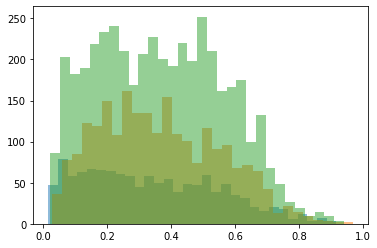

In [107]:
a = plt.hist(tt.loc[(tt.PxlMin_grp_le == 0) & (tt['any'] > 0), 'any'], bins=30, alpha=0.5)
a = plt.hist(tt.loc[(tt.PxlMin_grp_le == 1) & (tt['any'] > 0), 'any'], bins=30, alpha=0.5)
a = plt.hist(tt.loc[(tt.PxlMin_grp_le == 2) & (tt['any'] > 0), 'any'], bins=30, alpha=0.5)

# Weighting

In [108]:
train_md = pd.concat([train_md, test_md], axis=0, sort=False).reset_index(drop=True)

In [126]:
weights = np.ones(len(train_md))

In [110]:
# remove categories which are empty for test

In [127]:
for col in (cols_le + cols_bool):
    tt = data_md[[col,'test2']].groupby(col).sum()
    empty_categories = tt.index.values[tt['test2']==0]
    if len(empty_categories) > 0:
        print(col, empty_categories, train_md[col].isin(empty_categories).sum())
        weights[train_md[col].isin(empty_categories)] = 0

In [128]:
pd.value_counts(weights)

1.0    752802
dtype: int64

In [85]:
# remove broken intercept values

In [130]:
if ((test_md.PixelRepresentation == 0) & (test_md.RescaleIntercept >= 0)).sum() == 0:
    weights[(train_md.PixelRepresentation == 0) & (train_md.RescaleIntercept >= 0)] = 0

In [131]:
pd.value_counts(weights)

1.0    752679
0.0       123
dtype: int64

In [88]:
# remove outlier image

In [132]:
weights[train_md.SOPInstanceUID == 'ID_b79eed528'] = 0

In [133]:
pd.value_counts(weights)

1.0    752678
0.0       124
dtype: int64

In [91]:
# scale weight according to (PxlMin_grp_le == 0) frequency

In [134]:
data_md['weights'] = np.nan
data_md.loc[~data_md.test2, 'weights'] = weights

In [135]:
data_filt = data_md.loc[data_md.weights.fillna(-1) != 0]

In [136]:
tt = pd.crosstab(data_filt.PxlMin_grp_le == 0, data_filt.test2)

In [138]:
ww = tt.loc[False,True] * tt.loc[True,False] / (tt.loc[True,True] * tt.loc[False,False])

In [139]:
weights[(train_md.PxlMin_grp_le != 0) & (weights > 0)] = ww

In [140]:
pd.value_counts(weights)

1.50692    451848
1.00000    300830
0.00000       124
dtype: int64

In [141]:
train_md['weights'] = weights

In [99]:
# For each of two groups (PxlMin_grp_le == 0) bring expected 'any' to equality

In [101]:
yuval_test = pickle.load(open(PATH_DISK/'yuval/ensemble_test_image_ids.pkl','rb'))
assert len(yuval_test) == len(test_md)

In [102]:
test_md['img_id'] = test_md.SOPInstanceUID.str.split('_').apply(lambda x: x[1])

In [103]:
#del test_md['yuval_idx']

In [104]:
df = pd.DataFrame(np.arange(len(yuval_test)), columns=['yuval_idx'])
df.index = yuval_test
test_md = test_md.join(df, on = 'img_id')

In [105]:
names_y = [
           'model_se_resnet101_version_new_splits_fullhead_resmodel_pool2_3_type_test_pred_ensamble_split_{}.pkl',
           'model_se_resnext101_32x4d_version_new_splits_fullhead_resmodel_pool2_3_type_test_pred_ensamble_split_{}.pkl'
           ]

In [106]:
preds_y = np.stack([torch.sigmoid(torch.stack([torch.stack(pickle.load(
    open(PATH_DISK/'yuval/OOF'/name.format(fold),'rb'))) for fold in range(3)])).numpy() for name in names_y])

In [107]:
preds_y = preds_y[:,:,:,test_md.yuval_idx]
preds_y = preds_y[:,:,:,:,np.array([5,0,1,2,3,4])]
preds_y = preds_y.mean((0,1,2))

In [110]:
np.corrcoef(test_md[all_ich].values.reshape(-1), preds_y.reshape(-1))

array([[1.        , 0.84122984],
       [0.84122984, 1.        ]])

In [111]:
test_md[all_ich] = preds_y
test_md['weights'] = 1

In [112]:
dd = pd.concat([train_md,test_md],axis=0,sort=False)
dd[['any','test','PxlMin_zero']].groupby(['test','PxlMin_zero']).mean()

any
test  PxlMin_zero          
False False        0.184171
      True         0.064994
True  False        0.336857
      True         0.117623

In [113]:
dd[['any','test','PxlMin_zero','any_series']].groupby(['test','PxlMin_zero','any_series']).mean()

any
test  PxlMin_zero any_series          
False False       False       0.000000
                  True        0.364969
      True        False       0.000000
                  True        0.336447
True  False       True        0.336857
      True        False       0.007970
                  True        0.313152

In [114]:
for val in train_md.PxlMin_zero.unique():
    w1 = train_md.loc[(train_md.PxlMin_zero == val) & (train_md.any_series == False),'weights'].sum()
    w2 = train_md.loc[(train_md.PxlMin_zero == val) & (train_md.any_series == True),'weights'].sum()
    s2 = train_md.loc[(train_md.PxlMin_zero == val) & (train_md.any_series == True),'any'].mean()
    s_test = test_md.loc[(test_md.PxlMin_zero == val),'any'].mean()
    
    multiplier = (s2/s_test-1)*w2/w1
    if multiplier < 0: multiplier = 0
    train_md.loc[(train_md.PxlMin_zero == val) & (train_md.any_series == False),'weights'] *= multiplier
    
    print('val:',val,'w1:',w1,'w2:',w2,'s2:',s2,'s_test:',s_test,'multiplier:',multiplier)

val: True w1: 183128.0 w2: 41140.0 s2: 0.3364473204520598 s_test: 0.11762268658555347 multiplier: 0.4179406855062941
val: False w1: 7628.049060015255 w2: 7848.043790520683 s2: 0.3649689716312057 s_test: 0.33685712984314603 multiplier: 0.08586012098398665


In [115]:
print(np.average(train_md.PxlMin_zero.values, weights=train_md.weights.values))
print(np.average(test_md.PxlMin_zero.values, weights=test_md.weights.values))

for val in train_md.PxlMin_zero.unique():
    print('val',val,'train avg',np.average(train_md.loc[train_md.PxlMin_zero == val, 'any'].values, 
                     weights=train_md.loc[train_md.PxlMin_zero == val, 'weights'].values))
    print('val',val,'test avg',np.average(test_md.loc[test_md.PxlMin_zero == val, 'any'].values, 
                     weights=test_md.loc[test_md.PxlMin_zero == val, 'weights'].values))

0.9326120313741701
0.9359220828824241
val True train avg 0.11560493047309137
val True test avg 0.11762268658555335
val False train avg 0.3388041432798556
val False test avg 0.33685712984314603


In [116]:
train_md.weights /=  train_md.weights.mean()

In [117]:
train_md.weights.value_counts()

0.187007    220682
0.016056    217939
2.233320    183128
5.343628     41265
0.000000     11242
0.458805         1
Name: weights, dtype: int64

In [118]:
test_md = train_md.loc[train_md.test].copy().reset_index(drop=True)
train_md = train_md.loc[~train_md.test].copy().reset_index(drop=True)

assert len(test_md) == 78545
assert len(train_md) == 674257

train_md.to_csv(PATH_WORK/'train_md.csv', index=False)
test_md.to_csv(PATH_WORK/'test_md.csv', index=False)